In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
from konlpy.tag import Okt
from gensim.models import Word2Vec
from collections import Counter

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# 데이터 로드
df = pd.read_csv("https://raw.githubusercontent.com/hongsukyi/Lectures/main/data/nsmc.txt", sep="\t")
df = df.dropna().drop_duplicates(['document']).reset_index(drop=True)

df['word_count'] = df['document'].apply(lambda x: len(str(x).split()))
df_sorted = df.sort_values(by='word_count', ascending=False).reset_index(drop=True)

df=df_sorted[:5000].copy()

df.replace("", float("NaN"), inplace=True)
df = df.dropna().reset_index(drop=True)
print('결측치 처리 이후:',len(df))
df = df.drop_duplicates(['document']).reset_index(drop=True)
print('중복 제거 이후:',len(df))
df['document'] = df['document'].str.replace(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
print('한글 아닌 문자 제거 이후:',len(df))

df['document'] = df['document'].apply(lambda x: ' '.join([token for token in x.split() if len(token) > 2]))
print('리뷰 길이가 짧은 것 제거 :',len(df))

df.head()


결측치 처리 이후: 5000
중복 제거 이후: 5000
한글 아닌 문자 제거 이후: 5000
리뷰 길이가 짧은 것 제거 : 5000


,id,document,label,word_count
0,6928782,쌕기들이 종교랑 보솤ㅋㅋㅋㅋㅋ 그라제 우덜이 미군이 써보지도 완전히 전쟁도 있었당께...,0,41
1,8330404,정유미 정준영 부부막둥이 윤한부부 나오면 채널로 최초로 부부가 재미없음 막둥이 윤한...,0,40
2,8525988,측정용 영화임 당신은 마음이 남에게 상처를 못하는 당신은 인문학예술은 당신의 분야가...,0,40
3,8153927,황당한 쓰레기같은 스토리 수준을 초월한 칭찬해 차라리 디워는 나와서 신기하기라도 도...,0,40
4,8120918,남자고 아비라면 김윤진 역보다 어미니의 아들입장이라면 저보다 평만보면 공자시구만ㅋㅋ...,1,40


In [3]:
# 짧은 문장 제거
okt = Okt()
def token_count(text):
    return len(okt.morphs(text, stem=True))

df = df[df['document'].apply(lambda x: token_count(x) >= 3)].reset_index(drop=True)

print(f"최종 데이터 크기: {len(df)}")

최종 데이터 크기: 4999


In [4]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로',
             '자', '에', '와', '한', '하다', '을', '적', '로', '인', '만',
             '다', '이다', '에서', '되다', '하고', '않다', '못', '고', '안', '것', '나', '그']

def clean_tokenize(text):
    tokens = okt.morphs(text, stem=True)
    return [w for w in tokens if w not in stopwords]

df['tokens'] = df['document'].apply(clean_tokenize)


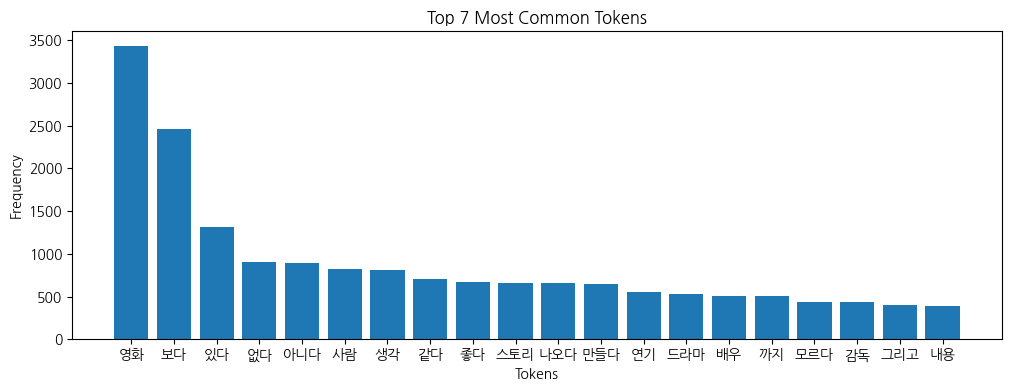

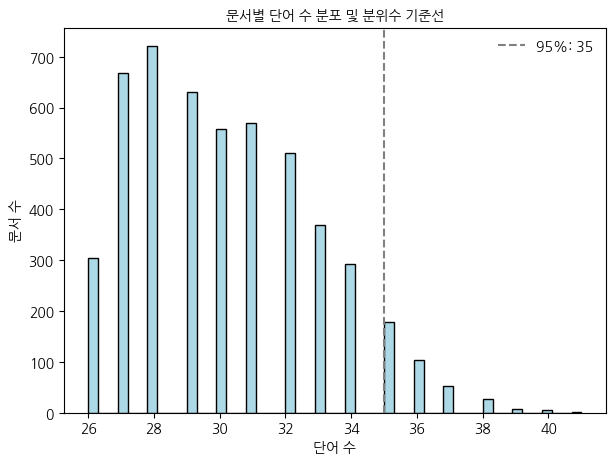

In [5]:
df_samples=df['tokens']
all_tokens = [token for tokens in df_samples for token in tokens]

counter = Counter(all_tokens)
common_words = counter.most_common(20) 
words, freqs = zip(*common_words)

plt.figure(figsize=(12,4))
plt.bar(words, freqs)
plt.title("Top 7 Most Common Tokens")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.show()



## 패딩을 위한 95% 분위값 출력
q95= df['word_count'].quantile([0.95])

plt.figure(figsize=(7, 5))
plt.hist(df['word_count'], bins=50, color='lightblue', edgecolor='black')


plt.axvline(x=q95.iloc[0], color='gray', linestyle='--', label=f'95%: {int(q95.iloc[0])}')
plt.title('문서별 단어 수 분포 및 분위수 기준선', fontsize=10)
plt.xlabel('단어 수', fontsize=10)
plt.ylabel('문서 수', fontsize=10)
plt.legend(frameon=False,fontsize=10)
plt.grid(False)
plt.show()

In [6]:
max_len = 35
embedding_dim = 100
w2v_model = Word2Vec(sentences=df['tokens'], vector_size=embedding_dim, window=5, min_count=5, workers=4, sg=1)


In [7]:
def tokens_to_w2v_sequence(tokens_list, model, max_len, embedding_dim):
    X_w2v_seq = []
    for tokens in tokens_list:
        vecs = []
        for word in tokens[:max_len]:
            if word in model.wv:
                vecs.append(model.wv[word])
            else:
                vecs.append(np.zeros(embedding_dim))
        while len(vecs) < max_len:
            vecs.append(np.zeros(embedding_dim))
        X_w2v_seq.append(vecs)
    return np.array(X_w2v_seq)

X = tokens_to_w2v_sequence(df['tokens'], w2v_model, max_len, embedding_dim)
y = np.array(df['label'])

print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (4999, 35, 100), y shape: (4999,)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model_gap = Sequential([
    GlobalAveragePooling1D(input_shape=(max_len, embedding_dim)),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_flat = Sequential([
    Flatten(input_shape=(max_len, embedding_dim)),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_dict = { 'flat': model_flat, 'gap': model_gap}
choice = 'gap'
model = model_dict[choice]


In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_split=0.1, callbacks=[early_stop], verbose=1)


Epoch 1/30
127/127 [==============================] - 2s 6ms/step - loss: 0.6729 - accuracy: 0.5796 - val_loss: 0.6877 - val_accuracy: 0.5667
Epoch 2/30
127/127 [==============================] - 1s 4ms/step - loss: 0.6507 - accuracy: 0.6145 - val_loss: 0.6411 - val_accuracy: 0.6622
Epoch 3/30
127/127 [==============================] - 1s 5ms/step - loss: 0.6407 - accuracy: 0.6340 - val_loss: 0.6249 - val_accuracy: 0.6800
Epoch 4/30
127/127 [==============================] - 1s 5ms/step - loss: 0.6362 - accuracy: 0.6419 - val_loss: 0.6171 - val_accuracy: 0.6778
Epoch 5/30
127/127 [==============================] - 1s 5ms/step - loss: 0.6394 - accuracy: 0.6409 - val_loss: 0.6148 - val_accuracy: 0.6756
Epoch 6/30
127/127 [==============================] - 1s 5ms/step - loss: 0.6327 - accuracy: 0.6436 - val_loss: 0.6045 - val_accuracy: 0.6800
Epoch 7/30
127/127 [==============================] - 1s 4ms/step - loss: 0.6198 - accuracy: 0.6634 - val_loss: 0.6028 - val_accuracy: 0.6911
Epoch 

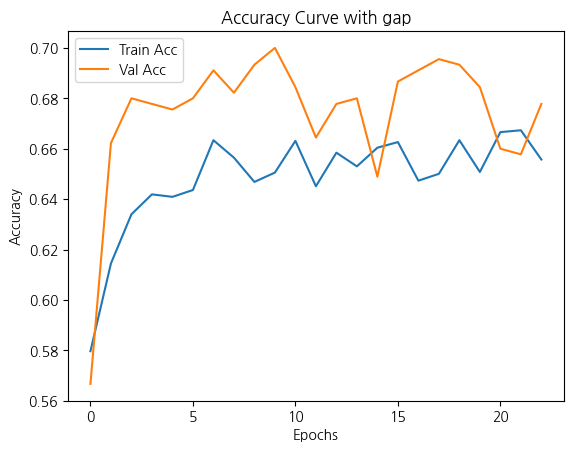

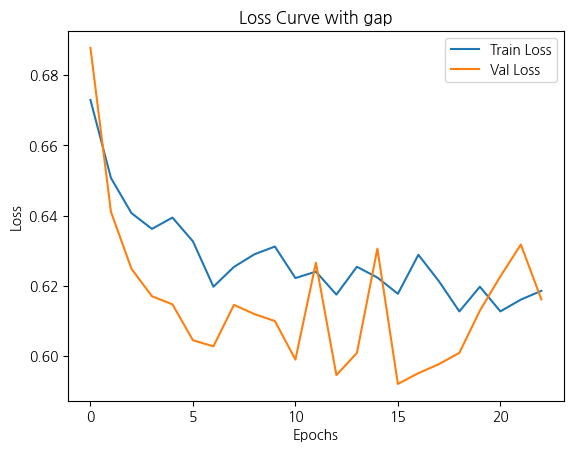

Test Accuracy: 0.7080, Loss: 0.5701


In [21]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title(f"Accuracy Curve with {choice}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f"Loss Curve with {choice}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 최종 평가
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}, Loss: {loss:.4f}")
